# Intro
### PCA
 - Clustering이 데이터셋을 근접도 기반으로 나눈 것이라면, PCA는 데이터셋을 분산 기반으로 나눈 것
 - 이는 데이터 내 중요한 관계를 도출하고 유의미한 Feature를 생성할 수 있다.
 - PCA이전, Scaling을 실시해야 표준화된 분산이 correlation을 의미하며, 실시하지 않는다면 이는 Covariance를 의미하게 된다.
 - 즉, PCA 이전에 스케일링을 해주자!

### 수학적 설명
 - 각 변수의 조합에 있어 최대 분산을 만드는 축으로 PCA를 실시한다.
 - 즉, PCA는 최대분산을 가진 축


# PCA in Feature Engineering
 - 차원축소
 - 이상치 탐지
 - 노이즈 제거
 - 변수간 상관관계 제거
 
### PCA 주의사항
 - Only continuous data
 - 스케일링!!
 - 이상치 제거 후 실시할 것

# Exercise

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from sklearn.feature_selection import mutual_info_regression


plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)


def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


df = pd.read_csv("./data/autos.csv")

In [3]:
# PCA전 스케일링
features = ["highway_mpg", "engine_size", "horsepower", "curb_weight"]

X = df.copy()
y = X.pop('price')
X = X.loc[:, features]

# Standardize
X_scaled = (X - X.mean(axis=0)) / X.std(axis=0)

In [4]:
# PCA실시
from sklearn.decomposition import PCA

# Create principal components
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Convert to dataframe
component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pca = pd.DataFrame(X_pca, columns=component_names)

X_pca.head()

,PC1,PC2,PC3,PC4
0,0.382486,-0.400222,0.124122,0.169539
1,0.382486,-0.400222,0.124122,0.169539
2,1.550890,-0.107175,0.598361,-0.256081
3,-0.408859,-0.425947,0.243335,0.013920
4,1.132749,-0.814565,-0.202885,0.224138


In [12]:
pca.components_.T

array([[-0.4923469 ,  0.77089183,  0.07014167, -0.39799556],
       [ 0.50385865,  0.62670948,  0.01996004,  0.59410713],
       [ 0.50044809,  0.01378838,  0.73109336, -0.46353435],
       [ 0.50326205,  0.11300841, -0.67836881, -0.52323242]])

In [5]:
# PCA구성 : PCA1 = -0.492*highway_mpg + 0.504*engine_size + 0.500*horsepower + 0.503*curb_weight
loadings = pd.DataFrame(
    pca.components_.T,  
    columns=component_names,  
    index=X.columns,  
)
loadings

,PC1,PC2,PC3,PC4
highway_mpg,-0.492347,0.770892,0.070142,-0.397996
engine_size,0.503859,0.626709,0.019960,0.594107
horsepower,0.500448,0.013788,0.731093,-0.463534
curb_weight,0.503262,0.113008,-0.678369,-0.523232


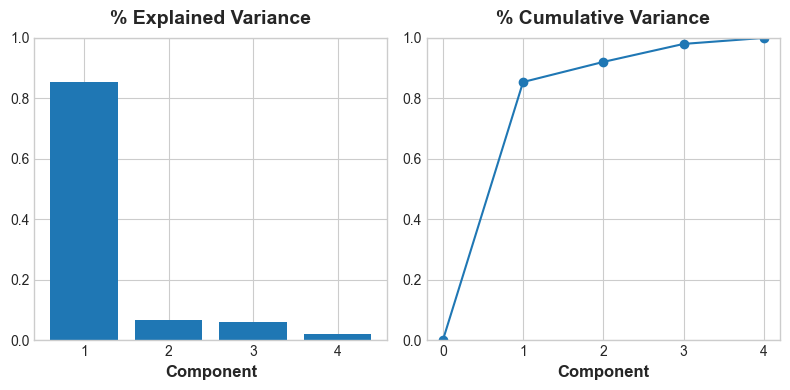

In [6]:
# Plotting Variance --> pc1이 거의 대다수의 설명력을 차지
'''
Recall that the signs and magnitudes of a component's loadings tell us what kind of variation it's captured. 
The first component (PC1) shows a contrast between large, powerful vehicles with poor gas milage, and smaller,
more economical vehicles with good gas milage. 
We might call this the "Luxury/Economy" axis. 
The next figure shows that our four chosen features mostly vary along the Luxury/Economy axis.

왜 이게 럭셔리, 이코노미 축이라는 결론이 될까?
'''
plot_variance(pca);

In [7]:
# PC1이 가장 큰 MI값을 가짐 (당연한결과)
mi_scores = make_mi_scores(X_pca, y, discrete_features=False)
mi_scores

PC1    1.012277
PC2    0.378955
PC3    0.306807
PC4    0.204361
Name: MI Scores, dtype: float64

In [8]:
# Show dataframe sorted by PC3 --> PC3는 curb_weight가 작을수록, horsepower가 큰 경향을 보임 --> 이것은 스포츠카 vs 웨건 구분?
idx = X_pca["PC3"].sort_values(ascending=False).index
cols = ["make", "body_style", "horsepower", "curb_weight"]
df.loc[idx, cols]

,make,body_style,horsepower,curb_weight
117,porsche,hardtop,207,2756
118,porsche,hardtop,207,2756
119,porsche,convertible,207,2800
45,jaguar,sedan,262,3950
96,nissan,hatchback,200,3139
...,...,...,...,...
59,mercedes-benz,wagon,123,3750
61,mercedes-benz,sedan,123,3770
101,peugot,wagon,95,3430
105,peugot,wagon,95,3485


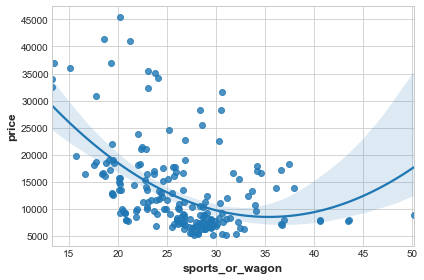

In [16]:
# 잘구분을 못하는 것 같으니 비율로 산정 (PCA에서 분산이 낮으니, 생각보다 설명력도 낮은듯 싶다.)
df["sports_or_wagon"] = X.curb_weight / X.horsepower
sns.regplot(x="sports_or_wagon", y='price', data=df, order=2); # regplot의 차수: order ---> order:2면 2차함수

# 실습

In [17]:
# Setup feedback system
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)


def apply_pca(X, standardize=True):
    # Standardize
    if standardize:
        X = (X - X.mean(axis=0)) / X.std(axis=0)
    # Create principal components
    pca = PCA()
    X_pca = pca.fit_transform(X)
    # Convert to dataframe
    component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=component_names)
    # Create loadings
    loadings = pd.DataFrame(
        pca.components_.T,  # transpose the matrix of loadings
        columns=component_names,  # so the columns are the principal components
        index=X.columns,  # and the rows are the original features
    )
    return pca, X_pca, loadings


def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs


def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def score_dataset(X, y, model=XGBRegressor()):
    # Label encoding for categoricals
    for colname in X.select_dtypes(["category", "object"]):
        X[colname], _ = X[colname].factorize()
    # Metric for Housing competition is RMSLE (Root Mean Squared Log Error)
    score = cross_val_score(
        model, X, y, cv=5, scoring="neg_mean_squared_log_error",
    )
    score = -1 * score.mean()
    score = np.sqrt(score)
    return score


df = pd.read_csv("./data/ames.csv")

In [18]:
features = [
    "GarageArea",
    "YearRemodAdd",
    "TotalBsmtSF",
    "GrLivArea",
]

print("Correlation with SalePrice:\n")
print(df[features].corrwith(df.SalePrice)) # SalePrice와 상관계수 산출

Correlation with SalePrice:

GarageArea      0.640138
YearRemodAdd    0.532974
TotalBsmtSF     0.632529
GrLivArea       0.706780
dtype: float64


In [19]:
X = df.copy()
y = X.pop("SalePrice")
X = X.loc[:, features]

# `apply_pca`, defined above, reproduces the code from the tutorial
pca, X_pca, loadings = apply_pca(X)
print(loadings) # PC1: 모든것이 클수록 좋음 --> 이는 이 값들이 큰 집 VS 작은 집에 따라 Salesprice변동이 큰 것을 의미

                   PC1       PC2       PC3       PC4
GarageArea    0.541229  0.102375 -0.038470  0.833733
YearRemodAdd  0.427077 -0.886612 -0.049062 -0.170639
TotalBsmtSF   0.510076  0.360778 -0.666836 -0.406192
GrLivArea     0.514294  0.270700  0.742592 -0.332837


In [20]:
# PCA로 만든 변수를 같이하여 모델링
X = df.copy()
y = X.pop("SalePrice")

# YOUR CODE HERE: Add new features to X.
X = X.join(X_pca) # PCA로 차원축소한 것들을 함께 모델링에 대입!

score = score_dataset(X, y)
print(f"Your score: {score:.5f} RMSLE")

Your score: 0.13707 RMSLE


##### 이상치탐지

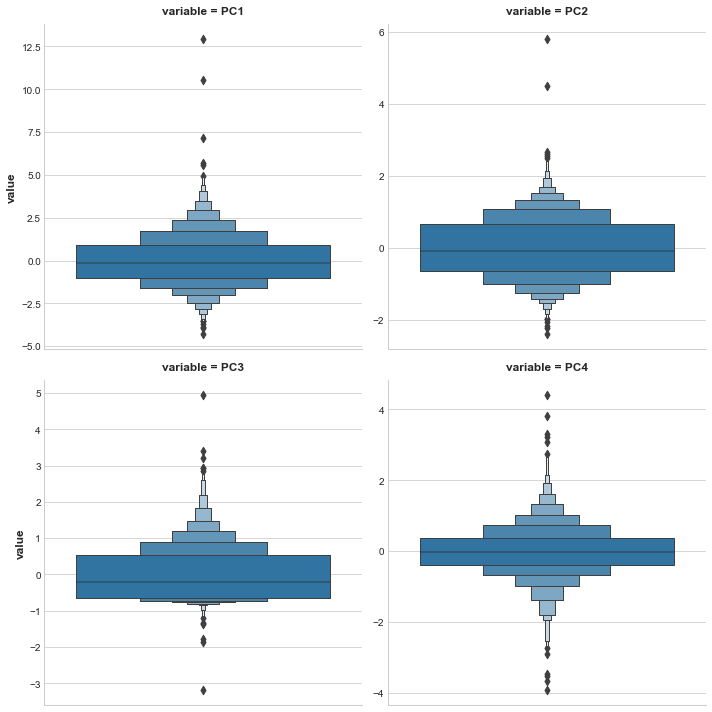

In [22]:
# 이상치탐지를 위한 시각화
sns.catplot(
    y="value",
    col="variable",
    data=X_pca.melt(),
    kind='boxen',
    sharey=False,
    col_wrap=2,
);

In [23]:
# PC1의 경우 Edwards 지역의 Partial형태로 판매되는 것들이 이상치로 보임. 우리가 공개시장에 대해 예측할 때는 이들을 제거하는게 합리적
# (위 근거는 도메인 놀리지 바탕이나, 난 왜 그런진 모르겟다,,,)
component = "PC1"

idx = X_pca[component].sort_values(ascending=False).index
df.loc[idx, ["SalePrice", "Neighborhood", "SaleCondition"] + features]

,SalePrice,Neighborhood,SaleCondition,GarageArea,YearRemodAdd,TotalBsmtSF,GrLivArea
1498,160000,Edwards,Partial,1418.0,2008,6110.0,5642.0
2180,183850,Edwards,Partial,1154.0,2009,5095.0,5095.0
2181,184750,Edwards,Partial,884.0,2008,3138.0,4676.0
1760,745000,Northridge,Abnorml,813.0,1996,2396.0,4476.0
1767,755000,Northridge,Normal,832.0,1995,2444.0,4316.0
...,...,...,...,...,...,...,...
662,59000,Old_Town,Normal,0.0,1950,416.0,599.0
2679,80500,Brookside,Normal,0.0,1950,0.0,912.0
2879,51689,Iowa_DOT_and_Rail_Road,Abnorml,0.0,1950,0.0,729.0
780,63900,Sawyer,Normal,0.0,1950,0.0,660.0
